<a href="https://colab.research.google.com/github/buchijw/Long_ML_Course/blob/main/5_Virtual_Screening_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Package**

In [1]:
# !pip install rdkit-pypi mols2grid tqdm

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from pathlib import Path
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools
from rdkit.Chem.Draw import IPythonConsole 
import os
os.chdir("./Data/")

#  **2. Lead-likeness and Lipinski's rule of five (Ro5)**

[<strong>Lead</strong> compounds](https://en.wikipedia.org/wiki/Lead_compound) are developmental drug candidates with promising properties. They are used as starting structures and modified with the aim to develop effective drugs. Besides bioactivity (_compound binds to the target of interest_), also favorable ADME properties are important criteria for the design of efficient drugs. 

The bioavailability of a compound is an important ADME property. Lipinski's rule of five (Ro5, [<i>Adv. Drug Deliv. Rev.</i> (1997), <b>23</b>, 3-25](https://www.sciencedirect.com/science/article/pii/S0169409X96004231)) was introduced to estimate the bioavailability of a compound solely based on its chemical structure.
The Ro5 states that poor absorption or permeation of a compound is more probable if the chemical structure violates more than one of the following rules:

- Molecular weight (MWT) <= 500 Da
- Number of hydrogen bond acceptors (HBAs) <= 10
- Number of hydrogen bond donors (HBD) <= 5 
- Calculated LogP (octanol-water coefficient) <= 5

Note: All numbers in the Ro5 are multiples of five; this is the origin of the rule's name.

Additional remarks:

- [LogP](https://en.wikipedia.org/wiki/Partition_coefficient) is also called partition coefficient or octanol-water coefficient. It measures the distribution of a compound, usually between a hydrophobic (e.g. 1-octanol) and a hydrophilic (e.g. water) phase. 
- Hydrophobic molecules might have a reduced solubility in water, while more hydrophilic molecules (e.g. high number of hydrogen bond acceptors and donors) or large molecules (high molecular weight) might have more difficulties in passing phospholipid membranes.

TPSA < 140

**Medicinal Chemistry Rules**

1. [QED](https://www.nature.com/articles/nchem.1243)
- A measure of drug-likeness based on the concept of desirability. QED is calculated by integrating the outputs of the desirability functions based on eight drug-likeness related properties, including MW, log P, NHBA, NHBD, PSA, Nrotb, the number of aromatic rings (NAr), and the number of alerts for undesirable functional groups. 
- Results interpretation: The mean QED is 0.67 for the attractive compounds, 0.49 for the unattractive compounds and 0.34 for the unattractive compounds considered too complex.

2. [SAscore](https://jcheminf.biomedcentral.com/articles/10.1186/1758-2946-1-8)
- Synthetic accessibility score is designed to estimate ease of synthesis of drug-like molecules, based on a combination of fragment contributions and a complexity penalty. The score is between 1 (easy to make) and 10 (very difficult to make). The synthetic accessibility score (SAscore) is calculated as a combination of two components: \text { SAscore }=\text { fragmentScore - complexityPenalty } SAscore = fragmentScore - complexityPenalty 
- Results interpretation: high SAscore: ≥ 6, difficult to synthesize; low SAscore: < 6, easy to synthesize

3. [Fsp3](https://pubs.acs.org/doi/10.1021/jm901241e)
- Fsp3, the number of sp3 hybridized carbons/total carbon count, is used to determine the carbon saturation of molecules and characterize the complexity of the spatial structure of molecules. It has been demonstrated that the increased saturation measured by Fsp3 and the number of chiral centers in the molecule increase the clinical success rate, which might be related to the increased solubility, or the fact that the enhanced 3D features allow small molecules to occupy more target space.
- Results interpretation: Fsp3 ≥ 0.42 is considered a suitable value.

4. [Lipinski Rule](https://www.sciencedirect.com/science/article/abs/pii/S0169409X00001290?via%3Dihub)
- Content: MW≤500; logP≤5; Hacc≤10; Hdon≤5
- Results interpretation: If two properties are out of range, a poor absorption or permeability is possible, one is acceptable.

5. [Pfizer Rule](https://www.sciencedirect.com/science/article/abs/pii/S0960894X08008500?via%3Dihub)
- Content: logP > 3; TPSA < 75
- Results interpretation: Compounds with a high log P (>3) and low TPSA (< 75) are likely to be toxic.

6. [GSK Rule](https://pubs.acs.org/doi/10.1021/jm701122q)
- Content: MW ≤ 400; logP ≤ 4
- Results interpretation: Compounds satisfying the GSK rule may have a more favorable ADMET profile.

7. [Golden Triangle](https://www.sciencedirect.com/science/article/abs/pii/S0960894X09011858?via%3Dihub)
- Content: 200 ≤MW ≤50; -2 ≤ logD ≤5     (logP)
- Results interpretation: Compounds satisfying the GoldenTriangle rule may have a more favourable ADMET profile.

8. [PAINS](https://pubs.acs.org/doi/10.1021/jm901137j)
- Pan Assay Interference Compounds (PAINS) is one of the most famous frequent hitters filters, which comprises 480 substructures derived from the analysis of FHs determined by six target-based HTS assay. By application of these filters, it is easier to screen false positive hits and to flag suspicious compounds in screening databases. One of the most authoritative medicine magazines Journal of Medicinal Chemistry even requires authors to provide the screening results with the PAINS alerts of active compounds when submitting manuscripts.


9. [ADMETlab 2.0](https://admetmesh.scbdd.com/explanation/index)

# **3. Example** 

### 3.1. Define and visualize example molecules

Before working with the whole dataset retrieved from ChEMBL, we pick four example compounds to investigate their chemical properties.
We draw four example molecules from their SMILES.

In [5]:
smiles = [
    "CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N1)C(C(C)CC=CC)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C",
    "CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C",
    "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=CC2=C(CCCC2(C)C)C)C)C",
    "CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O",
]
names = ["cyclosporine", "clozapine", "beta-carotene", "cannabidiol"]

First, we combine the names and SMILES of the molecules, together with their structure, in a DataFrame.

,name,smiles,ROMol
0,cyclosporine,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,
1,clozapine,CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C,
2,beta-carotene,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...,
3,cannabidiol,CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O,

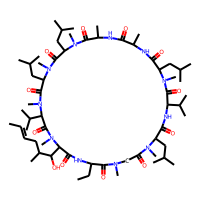
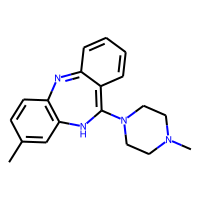
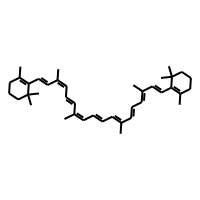
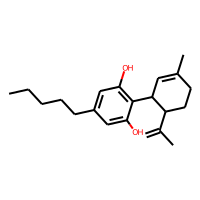

In [6]:
molecules = pd.DataFrame({"name": names, "smiles": smiles})
PandasTools.AddMoleculeColumnToFrame(molecules, "smiles")
molecules

### 3.2. Calculate and plot molecular properties for Ro5

1. Calculate molecular weight, number of hydrogen bond acceptors and donors, and logP using some of the [descriptors](http://www.rdkit.org/docs/GettingStartedInPython.html#descriptor-calculation) available in `rdkit`.

In [16]:
from tqdm.auto import tqdm
tqdm.pandas()
molecules["molecular_weight"] = molecules["ROMol"].progress_apply(Descriptors.ExactMolWt)
molecules["n_hba"] = molecules["ROMol"].progress_apply(Descriptors.NumHAcceptors)
molecules["n_hbd"] = molecules["ROMol"].progress_apply(Descriptors.NumHDonors)
molecules["logp"] = molecules["ROMol"].progress_apply(Descriptors.MolLogP)
molecules["tpsa"] = molecules["ROMol"].progress_apply(Descriptors.TPSA)
# Colors are used for plotting the molecules later
molecules["color"] = ["red", "green", "blue", "cyan"]
# NBVAL_CHECK_OUTPUT
molecules[["molecular_weight", "n_hba", "n_hbd", "logp", "tpsa"]]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,molecular_weight,n_hba,n_hbd,logp,tpsa
0,1201.841368,12,5,3.26900,278.80
1,306.184447,4,1,1.68492,30.87
2,536.438202,0,0,12.60580,0.00
3,314.224580,2,2,5.84650,40.46


,name,smiles,ROMol,molecular_weight,n_hba,n_hbd,logp,color
0,cyclosporine,CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(...,,1201.841368,12,5,3.26900,red
1,clozapine,CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C,,306.184447,4,1,1.68492,green
2,beta-carotene,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=...,,536.438202,0,0,12.60580,blue
3,cannabidiol,CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O,,314.224580,2,2,5.84650,cyan

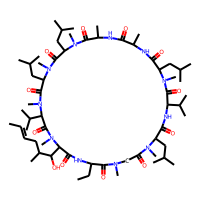
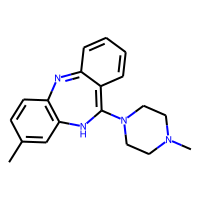
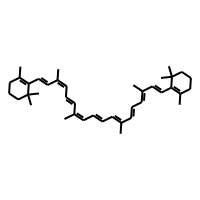
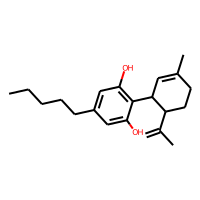

In [8]:
# Full preview
molecules

2. Plot the molecule properties as bar plots.

In [9]:
ro5_properties = {
    "molecular_weight": (500, "molecular weight (Da)"),
    "n_hba": (10, "# HBA"),
    "n_hbd": (5, "# HBD"),
    "logp": (5, "logP"),
}

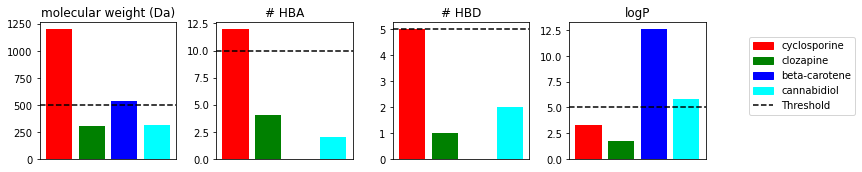

In [10]:
# Start 1x4 plot frame
fig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=4)
x = np.arange(1, len(molecules) + 1)
colors = ["red", "green", "blue", "cyan"]

# Create subplots
for index, (key, (threshold, title)) in enumerate(ro5_properties.items()):
    axes[index].bar([1, 2, 3, 4], molecules[key], color=colors)
    axes[index].axhline(y=threshold, color="black", linestyle="dashed")
    axes[index].set_title(title)
    axes[index].set_xticks([])

# Add legend
legend_elements = [
    mpatches.Patch(color=row["color"], label=row["name"]) for index, row in molecules.iterrows()
]
legend_elements.append(Line2D([0], [0], color="black", ls="dashed", label="Threshold"))
fig.legend(handles=legend_elements, bbox_to_anchor=(1.2, 0.8))

# Fit subplots and legend into figure
plt.tight_layout()
plt.show()

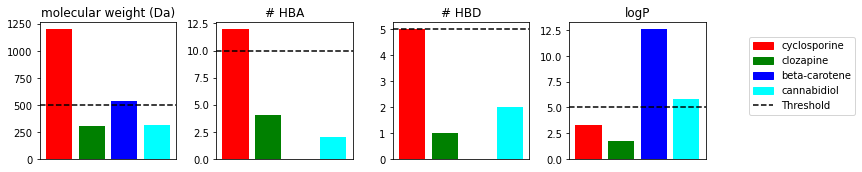

In [11]:
# Start 1x4 plot frame
fig, axes = plt.subplots(figsize=(10, 2.5), nrows=1, ncols=4)
x = np.arange(1, len(molecules) + 1)
colors = ["red", "green", "blue", "cyan"]

# Create subplots
for index, (key, (threshold, title)) in enumerate(ro5_properties.items()):
    axes[index].bar([1, 2, 3, 4], molecules[key], color=colors)
    axes[index].axhline(y=threshold, color="black", linestyle="dashed")
    axes[index].set_title(title)
    axes[index].set_xticks([])

# Add legend
legend_elements = [
    mpatches.Patch(color=row["color"], label=row["name"]) for index, row in molecules.iterrows()
]
legend_elements.append(Line2D([0], [0], color="black", ls="dashed", label="Threshold"))
fig.legend(handles=legend_elements, bbox_to_anchor=(1.2, 0.8))

# Fit subplots and legend into figure
plt.tight_layout()
plt.show()

In the bar chart, we compared the Ro5 properties for four example molecules with different properties. In the next steps, we will investigate for each compound whether it violates the Ro5.

### 3.3. Investigate compliance with Ro5

In [23]:
def calculate_ro5_properties(smiles, fullfill = 3):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.
    fullfill: int
        Number of rules fullfill RO5

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    tpsa = Descriptors.TPSA(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5, tpsa <= 140]
    ro5_fulfilled = sum(conditions) >= fullfill
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, tpsa, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "tpsa", "ro5_fulfilled"],
    )

Pfizer, GSK, Golden (logd -> logp)

In [24]:
Descriptors.TPSA(molecules)

ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcTPSA(DataFrame)
did not match C++ signature:
    CalcTPSA(RDKit::ROMol mol, bool force=False, bool includeSandP=False)

In [25]:
# NBVAL_CHECK_OUTPUT
for name, smiles in zip(molecules["name"], molecules["smiles"]):
    print(f"Ro5 fulfilled for {name}: {calculate_ro5_properties(smiles, 3)['ro5_fulfilled']}")

Ro5 fulfilled for cyclosporine: False
Ro5 fulfilled for clozapine: True
Ro5 fulfilled for beta-carotene: True
Ro5 fulfilled for cannabidiol: True


## 3.4. Apply EGFR dataset

In [26]:
molecules = pd.read_csv("EGFR_compounds.csv", index_col=0)
print(molecules.shape)
molecules.head()

(5568, 5)


,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910


Apply the Ro5 to all molecules.

In [27]:
# This takes a couple of seconds
ro5_properties = molecules["smiles"].progress_apply(calculate_ro5_properties)
ro5_properties.head()

  0%|          | 0/5568 [00:00<?, ?it/s]

,molecular_weight,n_hba,n_hbd,logp,tpsa,ro5_fulfilled
0,349.021459,3,1,5.2891,37.81,True
1,387.058239,5,1,4.9333,56.27,True
2,343.043258,5,1,3.5969,53.94,True
3,339.011957,4,2,4.0122,66.49,True
4,329.027607,5,2,3.5726,62.73,True


Concatenate molecules with Ro5 data.

In [28]:
molecules = pd.concat([molecules, ro5_properties], axis=1)
molecules.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,tpsa,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3,1,5.2891,37.81,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5,1,4.9333,56.27,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5,1,3.5969,53.94,True
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4,2,4.0122,66.49,True
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5,2,3.5726,62.73,True


In [29]:
# Note that the column "ro5_fulfilled" contains boolean values.
# Thus, we can use the column values directly to subset data.
# Note that ~ negates boolean values.
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

print(f"# compounds in unfiltered data set: {molecules.shape[0]}")
print(f"# compounds in filtered data set: {molecules_ro5_fulfilled.shape[0]}")
print(f"# compounds not compliant with the Ro5: {molecules_ro5_violated.shape[0]}")
# NBVAL_CHECK_OUTPUT

# compounds in unfiltered data set: 5568
# compounds in filtered data set: 5465
# compounds not compliant with the Ro5: 103


# **4. Radar Plot**

## 4.1. Radar charts concept

Molecular properties, such as the Ro5 properties, can be visualized in multiple ways  (e.g. craig plots, flower plots, or golden triangle) to support the interpretation by medicinal chemists ([<i>Drug. Discov. Today</i> (2011), <b>16(1-2)</b>, 65-72](https://www.ncbi.nlm.nih.gov/pubmed/21074634)).

Due to their appearance, [radar charts](https://en.wikipedia.org/wiki/Radar_chart) are sometimes also called "spider" or "cobweb" plots. 
They are arranged circularly in 360 degrees and have one axis, starting in the center, for each condition. The values for each parameter are plotted on the axis and connected with a line. 
A shaded area can indicate the region where the parameters meet the conditions.

![Radar plot for physicochemical properties](images/radarplot.png)

_Figure 2_: Radar plot displaying physico-chemical properties of a compound dataset


## 4.2. Visualize Ro5 properties (radar plot)

In [30]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        Properties (columns) for a set of items (rows).

    Returns
    -------
    pd.DataFrame
        Mean and standard deviation (columns) for different properties (rows).
    """
    # Generate descriptive statistics for property columns
    stats = dataframe.describe()
    # Transpose DataFrame (statistical measures = columns)
    stats = stats.T
    # Select mean and standard deviation
    stats = stats[["mean", "std"]]
    return stats

In [31]:
molecules_ro5_fulfilled_stats = calculate_mean_std(
    molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp", "tpsa"]]
)
molecules_ro5_fulfilled_stats
# NBVAL_CHECK_OUTPUT

,mean,std
molecular_weight,437.932358,99.933021
n_hba,6.229460,1.931015
n_hbd,1.914730,0.984345
logp,4.378191,1.377276
tpsa,86.196057,25.629535


In [33]:
molecules_ro5_violated_stats = calculate_mean_std(
    molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp", "tpsa"]]
)
molecules_ro5_violated_stats

,mean,std
molecular_weight,739.737766,225.358182
n_hba,11.456311,3.730575
n_hbd,4.300971,4.117954
logp,4.985489,2.992906
tpsa,188.080485,90.128503


In the following, we will define a few helper functions that are only used for radar plotting.

__Prepare y values__: 
The properties used for the Ro5 criteria are of different magnitudes. 
The MWT has a __threshold of 500__, whereas the number of HBAs and HBDs and the LogP have __thresholds of only 10, 5, and 5__, respectively. In order to visualize these different scales most simplistically, we will scale all property values to a __scaled threshold of 5__:

`scaled property value` = `property value` / `property threshold` * `scaled property threshold`

- scaled MWT = MWT / 500 * 5 = MWT / 100
- scaled HBA = HBA / 10 * 5 = HBA / 2
- scaled HBD = HBD / 5 * 5 = HBD
- scaled LogP = LogP / 5 * 5 = LogP

This results in a downscaling of the MWT by 100, HBA by 2, while HBD and LogP stay unchanged.

The following helper function performs such a scaling and will be used later during radar plotting.

In [34]:
def _scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have each an individually defined threshold.

    Parameters
    ----------
    stats : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Raise error if scaling keys and data_stats indicies are not matching
    for property_name in stats.index:
        if property_name not in thresholds.keys():
            raise KeyError(f"Add property '{property_name}' to scaling variable.")
    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)
    return stats_scaled

__Prepare x values:__
The following helper function returns the __angles of the physicochemical property axes for the radar chart__. For example, if we want to generate a radar plot for 4 properties, we want to set the axes at 0°, 90°, 180°, and 270°. The helper function returns such angles as radians.

In [35]:
def _define_radial_axes_angles(n_axes):
    """Define angles (radians) for radial (x-)axes depending on the number of axes."""
    x_angles = [i / float(n_axes) * 2 * math.pi for i in range(n_axes)]
    x_angles += x_angles[:1]
    return x_angles

In [45]:
def plot_radar(
    y,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max=None,
    output_path=None,
):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        Dataframe with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path
        If not None, save plot to file.
    """

    # Define radial x-axes angles -- uses our helper function!
    x = _define_radial_axes_angles(len(y))
    # Scale y-axis values with respect to a defined threshold -- uses our helper function!
    y = _scale_by_thresholds(y, thresholds, scaled_threshold)
    # Since our chart will be circular we append the first value of each property to the end
    y = y.append(y.iloc[0])

    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)

    # Plot data
    ax.fill(x, [scaled_threshold] * 6, "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")

    # From here on, we only do plot cosmetics
    # Set 0° to 12 o'clock
    ax.set_theta_offset(math.pi / 2)
    # Set clockwise rotation
    ax.set_theta_direction(-1)

    # Set y-labels next to 180° radius axis
    ax.set_rlabel_position(180)
    # Set number of radial axes' ticks and remove labels
    plt.xticks(x, [])
    # Get maximal y-ticks value
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    # Set axes limits
    plt.ylim(0, y_max)
    # Set number and labels of y axis ticks
    plt.yticks(
        range(1, y_max),
        ["5" if i == scaled_threshold else "" for i in range(1, y_max)],
        fontsize=16,
    )

    # Draw ytick labels to make sure they fit properly
    # Note that we use [:1] to exclude the last element which equals the first element (not needed here)
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
        ax.text(
            x=angle,
            y=y_max + 1,
            s=label,
            size=16,
            horizontalalignment=ha,
            verticalalignment="center",
        )

    # Add legend relative to top-left plot
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)

    # Save plot - use bbox_inches to include text boxes
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)

    plt.show()

In the following, we want to plot the radar chart for our two datasets:
1. Compounds that fulfill the Ro5
2. Compounds that violate the Ro5

Define input parameters that should stay the same for both radar charts:

In [46]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5, "tpsa": 140}
scaled_threshold = 5
properties_labels = [
    "Molecular weight (Da) / 100",
    "# HBA / 2",
    "# HBD",
    "LogP",
    "TPSA",
]
y_max = 8

1. We plot the radarplot for the dataset of compounds that __fulfill the Ro5__.

/var/folders/_g/19m11w9j13b9mvrnmc3w726h0000gn/T/ipykernel_2902/332170837.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(y.iloc[0])


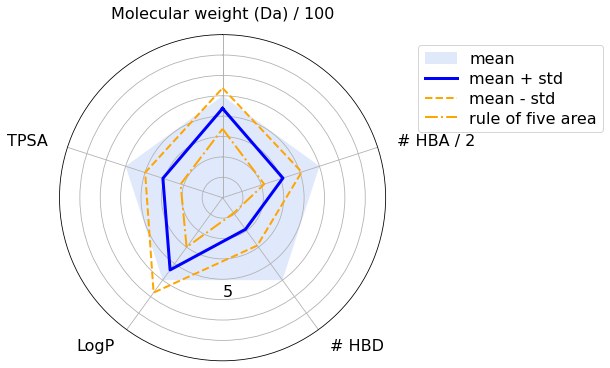

In [47]:
plot_radar(
    molecules_ro5_fulfilled_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

The blue square shows the area where a molecule's physicochemical properties are compliant with the Ro5. 
The blue line highlights the mean values, while the orange dashed lines show the standard deviations. 
We can see that the mean values never violate any of Lipinski's rules. 
However, according to the standard deviation, some properties have larger values then the Ro5 thresholds. 
This is acceptable because, according to the Ro5, one of the four rules can be violated.

2. We plot the radarplot for the dataset of compounds that __violate the Ro5__.

/var/folders/_g/19m11w9j13b9mvrnmc3w726h0000gn/T/ipykernel_2902/332170837.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(y.iloc[0])


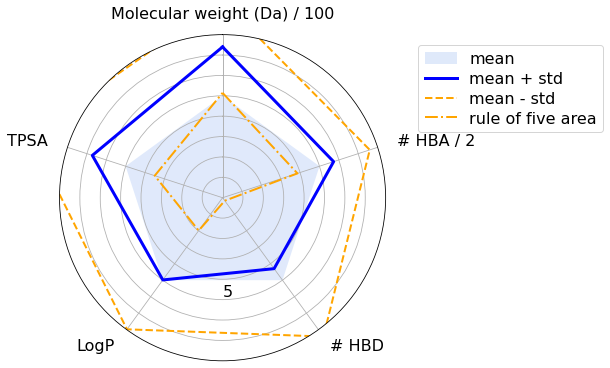

In [48]:
plot_radar(
    molecules_ro5_violated_stats,
    thresholds,
    scaled_threshold,
    properties_labels,
    y_max,
)

# **5. PAINS filter**

In [49]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [52]:
egfr_data = pd.read_csv("EGFR_compounds_lipinski.csv",
    index_col=0,
)
# Drop unnecessary information
print("Dataframe shape:", egfr_data.shape)
egfr_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
egfr_data.head()

Dataframe shape: (4635, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,True
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,True
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,True


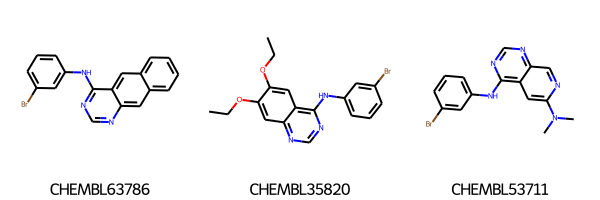

In [53]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(egfr_data, smilesCol="smiles")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(egfr_data.head(3).ROMol),
    legends=list(egfr_data.head(3).molecule_chembl_id),
)

### Filter for PAINS

The PAINS filter is already implemented in RDKit ([documentation](http://rdkit.org/docs/source/rdkit.Chem.rdfiltercatalog.html)). Such pre-defined filters can be applied via the `FilterCatalog` class. Let's learn how it can be used.

In [54]:
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [55]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = egfr_data.loc[clean]  # keep molecules without PAINS

  0%|          | 0/4635 [00:00<?, ?it/s]

In [56]:
# NBVAL_CHECK_OUTPUT
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(egfr_data)}")

Number of compounds with PAINS: 408
Number of compounds without PAINS: 4227


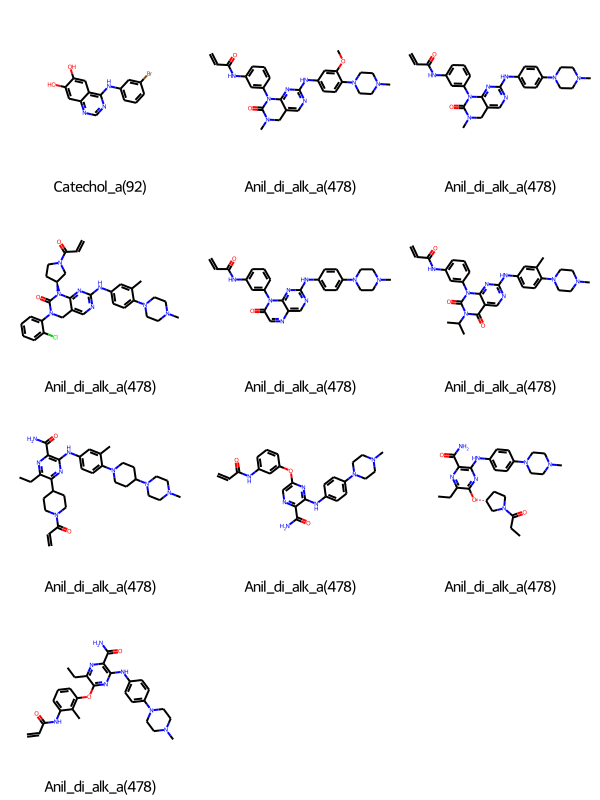

In [57]:
Chem.Draw.MolsToGridImage(
    list(matches.head(10).rdkit_molecule),
    legends=list(matches.head(10)["pains"]),
)

# **6. REOS**

REOS - Rapid Elimination Of Swill\n

Walters, Ajay, Murcko, "Recognizing molecules with druglike properties"

[Curr. Opin. Chem. Bio., 3 (1999), 384-387](https://doi.org/10.1016/S1367-5931(99)80058-1)
   

In [ ]:
!pip install tqdm seaborn mols2grid sklearn pingouin PyTDC 
!pip install git+https://github.com/PatWalters/useful_rdkit_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 11.2 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.2-py3-none-any.whl size=196206 sha256=aa27de6686fde8cee40d9c80ef86a7f936fb8c489afebb8b39f8005a84edc80d
  Stored in directory: /root/.cache/pip/wheels/11/5a/63/a6d32fc26fa462c731f65480bfb98ff7bd39b8ebcb4bc6c2fe
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=9b263695ce5004c346fe011737efd01268e97b8941d9d438ccf6f57299fc27e5
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple

In [ ]:
from rdkit import Chem
from tdc.single_pred import ADME
import mols2grid
from rdkit.Chem.Draw import MolsToGridImage
import useful_rdkit_utils as uru
reos = uru.REOS()

In [ ]:
molecules = pd.read_csv("EGFR_compounds.csv", index_col=0)
print(molecules.shape)
molecules.head()

In [ ]:
egfr_data = pd.read_csv("EGFR_compounds.csv", index_col=0)
# Drop unnecessary information
print("Dataframe shape:", egfr_data.shape)
egfr_data.drop(columns=["IC50", "units",], inplace=True)
egfr_data.head()

Dataframe shape: (5568, 5)


,molecule_chembl_id,smiles,pIC50
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910


## 6.1. Apply

In [ ]:
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

In [ ]:
reos = uru.REOS()
rule_path = reos.get_rule_file_location()
#reos.set_active_rule_sets()
reos.read_rules(rule_path,['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'])
egfr_data[['rule_set_name','reos']] = egfr_data.smiles.progress_apply(reos.process_smiles).to_list()

  0%|          | 0/5568 [00:00<?, ?it/s]

In [ ]:
egfr_data.head(25)

,molecule_chembl_id,smiles,pIC50,rule_set_name,reos,MolWt,LogP,HBD,HBA,TPSA
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,Dundee,Polycyclic aromatic hydrocarbon,350.219,5.28910,1.0,3.0,37.81
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,Inpharmatica,Filter9_metal,388.265,4.93330,1.0,5.0,56.27
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,Inpharmatica,Filter9_metal,344.216,3.59690,1.0,5.0,53.94
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,Inpharmatica,Filter9_metal,340.184,4.01220,2.0,4.0,66.49
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,Inpharmatica,Filter9_metal,330.189,3.57260,2.0,5.0,62.73
5,CHEMBL176582,Cn1cnc2cc3ncnc(Nc4cccc(Br)c4)c3cc21,11.000000,Inpharmatica,Filter9_metal,354.211,4.02260,1.0,5.0,55.63
6,CHEMBL29197,COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,10.602060,Inpharmatica,Filter9_metal,360.211,4.15310,1.0,5.0,56.27
7,CHEMBL174426,Cn1cnc2cc3c(Nc4cccc(Br)c4)ncnc3cc21,10.602060,Inpharmatica,Filter9_metal,354.211,4.02260,1.0,5.0,55.63
8,CHEMBL1243316,C#CCNC/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N...,10.522879,Dundee,Aliphatic long chain,477.927,4.75878,3.0,6.0,99.07
9,CHEMBL363815,C=CC(=O)Nc1ccc2ncnc(Nc3cc(Cl)c(Cl)cc3F)c2c1,10.431798,Dundee,halogenated ring,377.206,4.94380,2.0,4.0,66.91


In [ ]:
egfr_data[egfr_data['reos'] != 'ok']

,molecule_chembl_id,smiles,pIC50,rule_set_name,reos,MolWt,LogP,HBD,HBA,TPSA
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,Dundee,Polycyclic aromatic hydrocarbon,350.219,5.28910,1.0,3.0,37.81
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,Inpharmatica,Filter9_metal,388.265,4.93330,1.0,5.0,56.27
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,Inpharmatica,Filter9_metal,344.216,3.59690,1.0,5.0,53.94
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,Inpharmatica,Filter9_metal,340.184,4.01220,2.0,4.0,66.49
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,Inpharmatica,Filter9_metal,330.189,3.57260,2.0,5.0,62.73
...,...,...,...,...,...,...,...,...,...,...
5562,CHEMBL120564,COc1cc(C=C(C#N)C#N)cc(C)c1O,2.585027,Dundee,conjugated nitrile group,214.224,2.13978,1.0,4.0,77.04
5563,CHEMBL66879,O=C(O)/C=C/c1ccc(O)cc1,2.522879,Dundee,Michael acceptor,164.160,1.49000,2.0,2.0,57.53
5565,CHEMBL76587,N#CC(C#N)Cc1ccc(O)cc1,2.187087,SureChEMBL,geminal_dinitriles,172.187,1.59806,1.0,3.0,67.81
5566,CHEMBL490510,O=C(/C=C/c1ccc(O)c(O)c1)c1ccc(O[C@@H]2O[C@H](C...,1.721246,Dundee,catechol,450.396,-0.41620,8.0,11.0,197.37


In [ ]:
ro5_calc = uru.Ro5Calculator()
egfr_data[ro5_calc.names] = egfr_data.smiles.progress_apply(ro5_calc.calc_smiles).to_list()

  0%|          | 0/5568 [00:00<?, ?it/s]

In [ ]:
criteria_query = """reos == 'ok' and MolWt <= 500 and LogP <= 5 and HBD <= 5 and HBA <= 10 and TPSA <= 140"""
egfr_data.query(criteria_query)

,molecule_chembl_id,smiles,pIC50,rule_set_name,reos,MolWt,LogP,HBD,HBA,TPSA
30,CHEMBL166154,CNc1cc2c(Nc3cccc(Cl)c3)ncnc2cn1,9.721246,ok,ok,285.738,3.46350,2.0,5.0,62.73
37,CHEMBL316064,COc1cc2ncnc(Nc3cccc(C(F)(F)F)c3)c2cc1OC,9.619789,ok,ok,349.312,4.40940,1.0,5.0,56.27
43,CHEMBL2031303,CCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)CCN(C)C,9.568636,ok,ok,431.899,4.45480,2.0,6.0,79.38
50,CHEMBL2031305,CCOc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1NC(=O)CCN1C...,9.537602,ok,ok,473.936,4.22540,2.0,7.0,88.61
88,CHEMBL162821,CNc1cc2c(Nc3cccc(C)c3)ncnc2cn1,9.346787,ok,ok,265.320,3.11852,2.0,5.0,62.73
...,...,...,...,...,...,...,...,...,...,...
5455,CHEMBL57690,c1ccc(Nc2nccc(-c3cccnc3)n2)cc1,4.000000,ok,ok,248.289,3.28220,1.0,4.0,50.70
5458,CHEMBL299707,COc1ccccc1C(=O)Nc1cccc(Nc2nccc(-c3cccnc3)n2)c1,4.000000,ok,ok,397.438,4.54310,2.0,6.0,89.03
5460,CHEMBL324371,CN(c1ccccc1)c1ncnc2ccccc12,4.000000,ok,ok,235.290,3.39770,0.0,3.0,29.02
5522,CHEMBL280074,Cn1cnc2c(NCc3ccccc3)nc(NCCO)nc21,3.356547,ok,ok,298.350,1.37960,3.0,7.0,87.89


## 6.2. Examples

In [ ]:
reos = uru.REOS()

In [ ]:
rule_path = reos.get_rule_file_location()
rule_path

PosixPath('/root/.data/useful_rdkit_utils/data/alert_collection.csv')

In [ ]:
reos.rule_df.shape

(1251, 8)

In [ ]:
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

In [ ]:
reos.set_active_rule_sets(['BMS','PAINS'])

In [ ]:
reos.get_active_rule_sets()

array(['BMS', 'PAINS'], dtype=object)

In [ ]:
reos.active_rule_df.shape

(661, 8)

In [ ]:
reos.read_rules(rule_path,['Glaxo'])

In [ ]:
reos.active_rule_df.shape

(55, 8)

In [ ]:
gleevec_smiles = "Cc1ccc(cc1Nc2nccc(n2)c3cccnc3)NC(=O)c4ccc(cc4)CN5CCN(CC5)C"
reos.process_smiles(gleevec_smiles)

('ok', 'ok')

In [ ]:
egfr_data.smiles.progress_apply(reos.process_smiles)

  0%|          | 0/4635 [00:00<?, ?it/s]

0       (ok, ok)
1       (ok, ok)
2       (ok, ok)
3       (ok, ok)
4       (ok, ok)
          ...   
5562    (ok, ok)
5563    (ok, ok)
5564    (ok, ok)
5565    (ok, ok)
5567    (ok, ok)
Name: smiles, Length: 4635, dtype: object

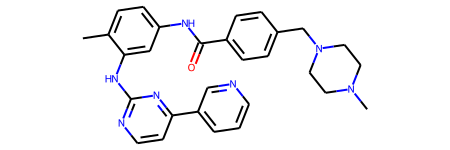

In [ ]:
gleevec_mol = Chem.MolFromSmiles(gleevec_smiles)
gleevec_mol

In [ ]:
reos.process_mol(gleevec_mol)

('ok', 'ok')

In [ ]:
hia_data = ADME(name = 'HIA_Hou').get_data()

Downloading...
100%|██████████| 40.1k/40.1k [00:00<00:00, 3.89MiB/s]
Loading...
Done!


In [ ]:
hia_data.head()

,Drug_ID,Drug,Y
0,Acetanilide,CC(=O)Nc1ccccc1,1
1,Acetazolamide.mol,CC(=O)Nc1nnc(S(N)(=O)=O)s1,1
2,Alfacalcidol,C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]2CC[C@H]3[C@@H...,1
3,Aminopyrine,Cc1c(N(C)C)c(=N)n(-c2ccccc2)n1C,1
4,Amosulalol.mol,COc1ccccc1OCCNC[C@@H](O)c1ccc(C)cc1S(N)(=O)=O,1


In [ ]:
hia_data[['rule_set_name','reos']] = hia_data.Drug.apply(reos.process_smiles).to_list()

In [ ]:
hia_data

,Drug_ID,Drug,Y,rule_set_name,reos
0,Acetanilide,CC(=O)Nc1ccccc1,1,ok,ok
1,Acetazolamide.mol,CC(=O)Nc1nnc(S(N)(=O)=O)s1,1,ok,ok
2,Alfacalcidol,C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]2CC[C@H]3[C@@H...,1,ok,ok
3,Aminopyrine,Cc1c(N(C)C)c(=N)n(-c2ccccc2)n1C,1,ok,ok
4,Amosulalol.mol,COc1ccccc1OCCNC[C@@H](O)c1ccc(C)cc1S(N)(=O)=O,1,ok,ok
...,...,...,...,...,...
573,Tiludronic_acid,O=P(O)(O)C(Cc1ccc(Cl)cc1)P(=O)(O)O,0,ok,ok
574,Zanamivir.mol,CC(=O)N[C@H]1[C@@H]([C@@H](O)[C@H](O)CO)OC(C(=...,0,ok,ok
575,Kanamycin.mol,CC(=O)NC[C@@H]1O[C@@H](O[C@H]2[C@@H](N)C[C@H](...,0,ok,ok
576,Amikacin.mol,NCC[C@@H](O)C(=O)N[C@@H]1C[C@H](N)[C@H](O[C@@H...,0,ok,ok


In [ ]:
hia_data[['rule_set_name','reos']].value_counts()

rule_set_name  reos                                     
ok             ok                                           526
Glaxo          I16 Betalactams                               19
               R1 Reactive alkyl halides                      9
               I11 Benzylic quaternary Nitrogen               5
               R17 acylhydrazide                              5
               N2 Polyenes                                    4
               I6 Epoxides, Thioepoxides, Aziridines          3
               N5 Cycloheximide derivatives                   3
               I2 Compounds with 4 or more acidic groups      1
               I4 Disulphides                                 1
               N1 Quinones                                    1
               N3 Saponin derivatives                         1
dtype: int64

In [ ]:
mols2grid.display(hia_data.sort_values(["rule_set_name","reos"]).query("reos != 'ok'"),
                  smiles_col="Drug",subset=["img","Drug_ID","reos","rule_set_name"])

In [ ]:
uru.rd_make_structures_pretty()
uru.rd_enable_svg()

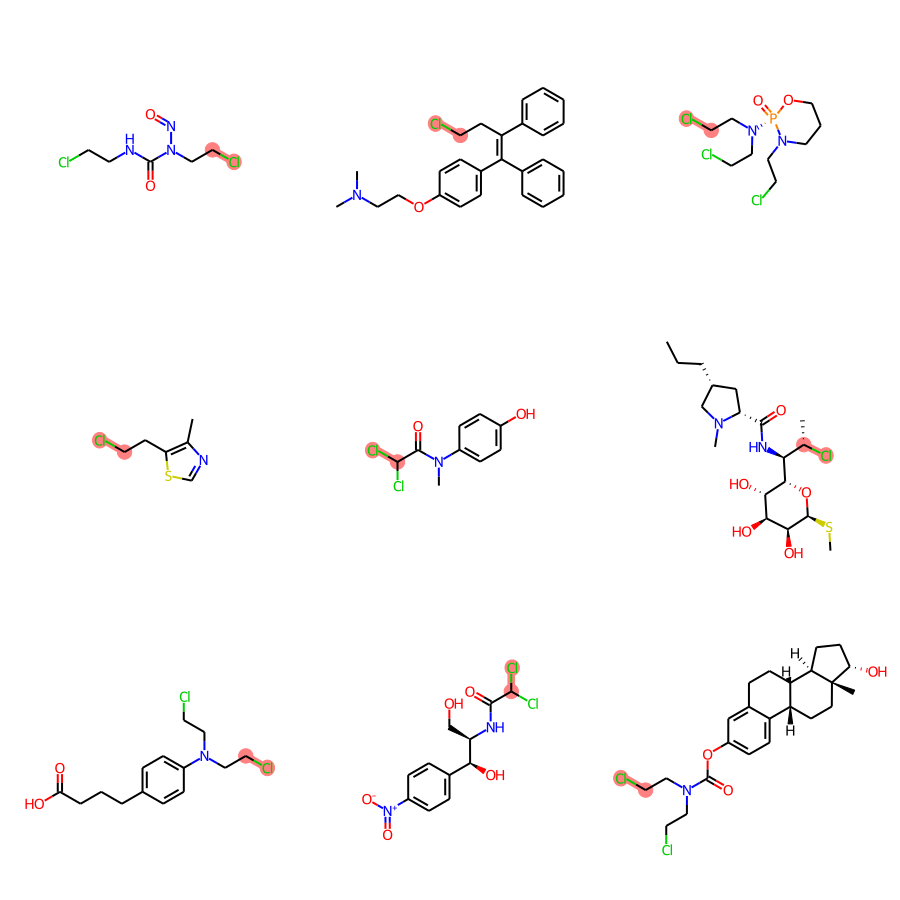

In [ ]:
rule_set = "Glaxo"
rule_name = 'R1 Reactive alkyl halides'
query = reos.active_rule_df.query("rule_set_name == @rule_set and description == @rule_name").pat.values
img = None
if len(query) != 1:
    print(f"no query match for {rule_set}/{rule_name}")
else:
    query = query[0]
    smiles_list = hia_data.query("rule_set_name == @rule_set and reos == @rule_name").Drug
    mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
    match_list = [x.GetSubstructMatch(query) for x in mol_list]
    img = MolsToGridImage(mol_list,molsPerRow=3,highlightAtomLists=match_list,subImgSize=(300, 300))
img

In [ ]:
ro5_calc = uru.Ro5Calculator()

In [ ]:
hia_data[ro5_calc.names] = hia_data.Drug.apply(ro5_calc.calc_smiles).to_list()

In [ ]:
hia_data

,Drug_ID,Drug,Y,rule_set_name,reos,MolWt,LogP,HBD,HBA,TPSA
0,Acetanilide,CC(=O)Nc1ccccc1,1,ok,ok,135.166,1.64500,1.0,1.0,29.10
1,Acetazolamide.mol,CC(=O)Nc1nnc(S(N)(=O)=O)s1,1,ok,ok,222.251,-0.85610,2.0,6.0,115.04
2,Alfacalcidol,C=C1/C(=C\C=C2/CCC[C@]3(C)[C@@H]2CC[C@H]3[C@@H...,1,ok,ok,400.647,6.58980,2.0,2.0,40.46
3,Aminopyrine,Cc1c(N(C)C)c(=N)n(-c2ccccc2)n1C,1,ok,ok,230.315,1.66969,1.0,4.0,36.95
4,Amosulalol.mol,COc1ccccc1OCCNC[C@@H](O)c1ccc(C)cc1S(N)(=O)=O,1,ok,ok,380.466,1.35302,3.0,6.0,110.88
...,...,...,...,...,...,...,...,...,...,...
573,Tiludronic_acid,O=P(O)(O)C(Cc1ccc(Cl)cc1)P(=O)(O)O,0,ok,ok,300.571,1.56400,4.0,2.0,115.06
574,Zanamivir.mol,CC(=O)N[C@H]1[C@@H]([C@@H](O)[C@H](O)CO)OC(C(=...,0,ok,ok,332.313,-3.57583,8.0,7.0,198.22
575,Kanamycin.mol,CC(=O)NC[C@@H]1O[C@@H](O[C@H]2[C@@H](N)C[C@H](...,0,ok,ok,526.540,-7.11400,11.0,15.0,285.69
576,Amikacin.mol,NCC[C@@H](O)C(=O)N[C@@H]1C[C@H](N)[C@H](O[C@@H...,0,ok,ok,585.608,-8.42420,13.0,17.0,331.94


In [ ]:
criteria_query = """reos == 'ok' and MolWt <= 500 and LogP <= 5 and HBD <= 5 and HBA <= 10 and TPSA <= 140"""

In [ ]:
hia_data.query(criteria_query)

,Drug_ID,Drug,Y,rule_set_name,reos,MolWt,LogP,HBD,HBA,TPSA
0,Acetanilide,CC(=O)Nc1ccccc1,1,ok,ok,135.166,1.64500,1.0,1.0,29.10
1,Acetazolamide.mol,CC(=O)Nc1nnc(S(N)(=O)=O)s1,1,ok,ok,222.251,-0.85610,2.0,6.0,115.04
3,Aminopyrine,Cc1c(N(C)C)c(=N)n(-c2ccccc2)n1C,1,ok,ok,230.315,1.66969,1.0,4.0,36.95
4,Amosulalol.mol,COc1ccccc1OCCNC[C@@H](O)c1ccc(C)cc1S(N)(=O)=O,1,ok,ok,380.466,1.35302,3.0,6.0,110.88
5,Anastrozole.mol,CC(C)(C#N)c1cc(Cn2cncn2)cc(C(C)(C)C#N)c1,1,ok,ok,293.374,2.92876,0.0,5.0,78.29
...,...,...,...,...,...,...,...,...,...,...
568,Hydrochlorothiazide.mol,NS(=O)(=O)c1cc2c(cc1Cl)NCNS2(=O)=O,1,ok,ok,297.745,-0.35130,3.0,5.0,118.36
569,Metolazone.mol,Cc1ccccc1N1C(=O)c2cc(S(N)(=O)=O)c(Cl)cc2N[C@@H]1C,1,ok,ok,365.842,2.71412,2.0,4.0,92.50
570,Reproterol,Cn1c(=O)c2c(ncn2CCCNC[C@@H](O)c2cc(O)cc(O)c2)n...,1,ok,ok,389.412,-0.44180,4.0,10.0,134.54
571,Tranexamic_acid.mol,NC[C@H]1CC[C@@H](C(=O)O)CC1,1,ok,ok,157.213,0.83610,2.0,2.0,63.32
